# Argumentative Causal Discovery with LLMs - CauseNet Synthetic Data

Notebook collecting results for causal discovery algorithm ABAPC using additional constraints from LLMs.

In [43]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
import numpy as np
from IPython.display import display
import pandas as pd
from scipy.stats import ttest_ind_from_stats
from itertools import combinations

pd.set_option('display.max_rows', 2000)

REPO_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(REPO_ROOT / 'utils'))

from plotting import *

save_figs = False
debug = False

RESULTS_DIR = REPO_ROOT / 'results'
VERSION = 'test_rnd_spc'

names_dict = {
    'random': 'Random',
    'pc': 'PC',
    'pc_max': 'Max-PC',
    'fgs': 'FGS',
    'spc': 'Shapley-PC',
    'mpc': 'MPC',
    'cpc': 'CPC',
    'abapc': 'ABAPC',
    'abapc_llm': 'ABAPC-LLM',
    'cam': 'CAM',
    'nt': 'NOTEARS-MLP',
    'mcsl': 'MCSL-MLP',
    'ges': 'GES',
    'aspcr': 'ASPCR',
    'llm_bfs': 'LLM-BFS',
}

symbols_dict = {
    'random': 'x',
    'pc': 'circle',
    'pc_max': 'circle-open',
    'fgs': 'triangle-up-dot',
    'spc': 'hexagon2-dot',
    'mpc': 'diamond-dot',
    'cpc': 'square-dot',
    'abapc': 'triangle-down-dot',
    'abapc_llm': 'triangle-down-open',
    'cam': 'star',
    'nt': 'pentagon-dot',
    'mcsl': 'cross-thin',
    'ges': 'circle-cross',
    'aspcr': 'diamond-open',
    'llm_bfs': 'square-open',
}

colors_dict = {
    'random': '#7f7f7f',
    'pc': main_blue,
    'pc_max': sec_blue,
    'fgs': sec_orange,
    'spc': sec_green,
    'mpc': main_green,
    'cpc': '#c678dd',
    'abapc': '#bcbd22',
    'abapc_llm': sec_purple,
    'cam': main_orange,
    'nt': sec_blue,
    'mcsl': '#bcbd22',
    'ges': '#17becf',
    'aspcr': sec_purple,
    'llm_bfs': "#e377c2", 
}

inverse_names = {v: k for k, v in names_dict.items()}

default_methods = ['Random', 'PC', 'Max-PC', 'FGS', 'NOTEARS-MLP', 'MPC', 'CPC', # 'ASPCR', 'Shapley-PC', 
                   'ABAPC', 'LLM-BFS', 'ABAPC-LLM']
runtime_methods = default_methods
methods = default_methods.copy()

DATASET_LABEL_OVERRIDES = {
    # 'dag_10_nodes_10_edges_degrees_ER': 'ER<br>|V|=10 |E|=10',
}

DATASET_INCLUDE = []  # e.g. ['dag_10_nodes_10_edges_degrees_ER']
DATASET_EXCLUDE = []
HEURISTIC_INCLUDE = []
GRAPH_TYPE_INCLUDE = []
NODE_INCLUDE = []
EDGE_INCLUDE = []
DATASET_REGEX = None  # optional regex applied to dataset_id

AGGREGATE_BY_SIZE_TYPE = True
INCLUDE_HEURISTIC_IN_LABEL = False

HEURISTIC_LABELS = {
    'none': 'No Heuristic',
    'degrees': 'Degrees',
    'semantics': 'Semantics',
}

GRAPH_TYPE_LABELS = {
    'er': 'ER',
    'sf': 'SF',
    'random': 'Random',
}

MODEL_ALIASES = {
    'ABAPC (Ours)': 'ABAPC',
    'ABAPC-LLM (Ours)': 'ABAPC-LLM',
    'ABAPC-LLM (beta)': 'ABAPC-LLM',
    'ABAPC-LLM (Beta)': 'ABAPC-LLM',
    'ABAPC LLM': 'ABAPC-LLM',
    'ASPCR-log': 'ASPCR',
}


EXTRA_MODELS = {}

RUN_CONFIGS = [
    {
        'results_dir': RESULTS_DIR,
        'version': 'test_rnd_spc',            # adjust to your first run
        'include_methods': ['Random', 'Shapley-PC'],
        'label': 'rnd_spc',
    },
    {
        'results_dir': RESULTS_DIR,
        'version': 'causenet_base',         # adjust to your second run
        'include_methods': ['NOTEARS-MLP', 'MPC', 'FGS'],
        'label': 'nt_mpc_fgs',
    },
    {
        'results_dir': RESULTS_DIR,
        'format': 'csv',
        'csv_path': 'merged_synthetic.csv',
        'csv_model_column': 'impl',
        'csv_model_mapping': {
            'org': 'ABAPC',
            'new': 'ABAPC-LLM',
        },
        'include_methods': ['ABAPC', 'ABAPC-LLM'],
        'label': 'agg_csv',
    },
    {
        'results_dir': RESULTS_DIR,
        'format': 'csv',
        'csv_path': 'causal-bfs-synthetic-results.csv',
        'csv_model_column': 'impl',
        'csv_model_mapping': {
            'llm-bfs': 'LLM-BFS',
        },
        'include_methods': ['LLM-BFS'],
        'label': 'agg_csv2',
    },
]


def parse_dataset_meta(dataset_id):
    parts = dataset_id.split('_')
    meta = {
        'dataset_id': dataset_id,
        'heuristic': None,
        'graph_type': None,
        'nodes': None,
        'edges': None,
    }
    try:
        if parts[0] == 'dag' and len(parts) >= 5:
            meta['nodes'] = int(parts[1])
            meta['edges'] = int(parts[3])
            if len(parts) >= 6:
                meta['heuristic'] = parts[5]
            if len(parts) >= 7:
                meta['graph_type'] = '_'.join(parts[6:])
    except (IndexError, ValueError):
        pass
    return meta

def size_type_label(n_nodes, n_edges, graph_type):
    graph_key = (str(graph_type).lower() if graph_type is not None else 'unknown')
    graph_label = GRAPH_TYPE_LABELS.get(graph_key, str(graph_type).replace('_', ' ').title() if graph_type is not None else 'Unknown')
    parts = []
    if pd.notna(n_nodes):
        parts.append(f"|V|={int(n_nodes)}")
    if pd.notna(n_edges):
        parts.append(f"|E|={int(n_edges)}")
    size_line = ' '.join(parts)
    return graph_label + (f"<br>{size_line}" if size_line else '')

def dataset_label_from_meta(meta):
    override = DATASET_LABEL_OVERRIDES.get(meta['dataset_id'])
    if override:
        return override
    base_label = size_type_label(meta.get('nodes'), meta.get('edges'), meta.get('graph_type'))
    if INCLUDE_HEURISTIC_IN_LABEL:
        heur = (meta.get('heuristic') or 'unknown').lower()
        heur_label = HEURISTIC_LABELS.get(heur, (meta.get('heuristic') or 'Unknown').replace('_', ' ').title())
        return f"{heur_label} - {base_label}"
    return base_label

def node_count_label(n_nodes):
    if pd.isna(n_nodes):
        return 'Unknown |V|'
    return f"|V|={int(n_nodes)}"


def graph_type_display(graph_type):
    if pd.isna(graph_type):
        return 'Unknown Type'
    key = str(graph_type).lower()
    return GRAPH_TYPE_LABELS.get(key, str(graph_type).replace('_', ' ').title())


def aggregate_metrics(df, group_cols, label_builder):
    if df.empty:
        return df.copy()
    required_cols = set(group_cols) | {'model', 'dataset_id'}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f'Missing columns for aggregation: {missing}')
    mean_cols = [col for col in df.columns if col.endswith('_mean')]
    std_cols = [col for col in df.columns if col.endswith('_std')]
    agg_dict = {col: 'mean' for col in mean_cols + std_cols}
    agg_dict['dataset_id'] = 'nunique'
    grouped = (
        df.groupby(group_cols + ['model'], dropna=False)
          .agg(agg_dict)
          .reset_index()
          .rename(columns={'dataset_id': 'graph_count'})
    )
    for col in ['n_nodes', 'n_edges']:
        if col in grouped:
            grouped[col] = pd.to_numeric(grouped[col], errors='coerce').astype('Int64')
    grouped['dataset_label'] = grouped.apply(label_builder, axis=1)
    grouped['dataset'] = grouped['dataset_label']
    grouped['graph_count'] = grouped['graph_count'].fillna(0).astype(int)
    return order_results(grouped)

def load_npy_table(path, columns):
    if not path.exists():
        raise FileNotFoundError(f'Missing results file: {path}')
    table = np.load(path, allow_pickle=True)
    df = pd.DataFrame(table, columns=columns)
    df['dataset'] = df['dataset'].astype(str)
    df['model'] = df['model'].astype(str)
    return df

COLUMNS_MAP = {
    'cpdag': ['dataset', 'model', 'elapsed_mean', 'elapsed_std', 'nnz_mean', 'nnz_std',
              'fdr_mean', 'fdr_std', 'tpr_mean', 'tpr_std', 'fpr_mean', 'fpr_std',
              'precision_mean', 'precision_std', 'recall_mean', 'recall_std',
              'F1_mean', 'F1_std', 'shd_mean', 'shd_std',
              'sid_low_mean', 'sid_low_std', 'sid_high_mean', 'sid_high_std'],
    'dag': ['dataset', 'model', 'elapsed_mean', 'elapsed_std', 'nnz_mean', 'nnz_std',
            'fdr_mean', 'fdr_std', 'tpr_mean', 'tpr_std', 'fpr_mean', 'fpr_std',
            'precision_mean', 'precision_std', 'recall_mean', 'recall_std',
            'F1_mean', 'F1_std', 'shd_mean', 'shd_std', 'sid_mean', 'sid_std'],
}

CSV_METRIC_MAP = {
    'dag': {
        'elapsed': 'time',
        'nnz': 'dag_nnz',
        'fdr': 'dag_fdr',
        'tpr': 'dag_tpr',
        'fpr': 'dag_fpr',
        'precision': 'dag_precision',
        'recall': 'dag_recall',
        'F1': 'dag_F1',
        'shd': 'dag_shd',
        'sid': 'dag_sid',
    },
    'cpdag': {
        'elapsed': 'time',
        'nnz': 'cpdag_nnz',
        'fdr': 'cpdag_fdr',
        'tpr': 'cpdag_tpr',
        'fpr': 'cpdag_fpr',
        'precision': 'cpdag_precision',
        'recall': 'cpdag_recall',
        'F1': 'cpdag_F1',
        'shd': 'cpdag_shd',
        'sid_low': 'cpdag_sid_low',
        'sid_high': 'cpdag_sid_high',
    },
}

def resolve_csv_path(spec, base_dir):
    csv_entry = spec.get('csv_path')
    if csv_entry is None:
        csv_entry = spec.get('csv_name', 'agg.csv')
    csv_path = Path(csv_entry)
    if not csv_path.is_absolute():
        csv_path = base_dir / csv_path
    return csv_path

def load_csv_results(kind, spec, columns, base_dir, csv_path=None):
    csv_path = csv_path or resolve_csv_path(spec, base_dir)
    if not csv_path.exists():
        raise FileNotFoundError(f'Missing CSV results file: {csv_path}')
    df = pd.read_csv(csv_path)
    dataset_col = spec.get('csv_dataset_column', 'dataset')
    model_col = spec.get('csv_model_column', 'model')
    df = df.rename(columns={dataset_col: 'dataset', model_col: 'model'})
    model_mapping = spec.get('csv_model_mapping')
    if model_mapping:
        df['model'] = df['model'].replace(model_mapping)
    df['dataset'] = df['dataset'].astype(str)
    df['model'] = df['model'].astype(str)
    metrics_map = CSV_METRIC_MAP[kind].copy()
    overrides = spec.get('csv_metric_map')
    if overrides:
        metrics_map.update(overrides)
    missing = [src for src in metrics_map.values() if src not in df.columns]
    if missing:
        raise ValueError(f'Missing columns in CSV results ({csv_path}): {missing}')
    rename_map = {src: name for name, src in metrics_map.items()}
    value_cols = list(rename_map.keys())
    df = df[['dataset', 'model'] + value_cols].rename(columns=rename_map)
    grouped = (
        df.groupby(['dataset', 'model'], as_index=False)
          .agg({col: ['mean', 'std'] for col in rename_map.values()})
    )
    flat_columns = []
    for col in grouped.columns:
        if isinstance(col, tuple):
            metric, agg = col
            if agg != '':
                flat_columns.append(f'{metric}_{agg}')
            else:
                flat_columns.append(metric)
        else:
            flat_columns.append(col)
    grouped.columns = flat_columns
    for metric in rename_map.values():
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'
        if mean_col not in grouped.columns:
            grouped[mean_col] = np.nan
        if std_col not in grouped.columns:
            grouped[std_col] = np.nan
    for col in columns:
        if col not in grouped.columns:
            print(f"Missing column in grouped results: {col}")
            grouped[col] = np.nan
    return grouped[columns]

def load_results(kind, run_specs=None):
    suffix = '_cpdag' if kind == 'cpdag' else ''
    columns = COLUMNS_MAP[kind]
    specs = run_specs or RUN_CONFIGS
    frames = []
    for spec in specs:
        base_dir = Path(spec.get('results_dir', RESULTS_DIR))
        include_methods = spec.get('include_methods')
        label = spec.get('label', spec.get('version', VERSION))
        fmt = str(spec.get('format', 'npy')).lower()
        if fmt == 'csv':
            csv_path = resolve_csv_path(spec, base_dir)
            if not csv_path.exists():
                print(f"[WARN] Missing results file: {csv_path}")
                continue
            df = load_csv_results(kind, spec, columns, base_dir, csv_path=csv_path)
        else:
            version = spec.get('version', VERSION)
            main_path = base_dir / f'stored_results_{version}{suffix}.npy'
            try:
                df = load_npy_table(main_path, columns)
            except FileNotFoundError:
                print(f"[WARN] Missing results file: {main_path}")
                continue

            for prefix, label_name in EXTRA_MODELS.items():
                extra_path = base_dir / f'stored_results_{prefix}_{version}{suffix}.npy'
                if extra_path.exists():
                    extra = load_npy_table(extra_path, columns)
                    extra['model'] = label_name
                    df = pd.concat([df, extra], ignore_index=True)

        df = df.rename(columns=lambda col: col.replace('sid', 'SID'))
        if 'model' in df:
            df['model'] = df['model'].replace(MODEL_ALIASES)
        if include_methods:
            df = df[df['model'].isin(include_methods)].reset_index(drop=True)
        df['run_label'] = label
        frames.append(df)

    if not frames:
        cols_with_label = columns + ['run_label']
        return pd.DataFrame(columns=cols_with_label)

    return pd.concat(frames, ignore_index=True)

def annotate_results(df, normalise_targets):
    df = df.copy()
    df['dataset_id'] = df['dataset'].astype(str)
    meta_list = [parse_dataset_meta(ds) for ds in df['dataset_id']]
    meta_df = pd.DataFrame(meta_list)
    if not meta_df.empty:
        meta_df = meta_df.rename(columns={'nodes': 'n_nodes', 'edges': 'n_edges'})
        df = pd.concat([df, meta_df[['n_nodes', 'n_edges', 'heuristic', 'graph_type']]], axis=1)
    label_map = {m['dataset_id']: dataset_label_from_meta(m) for m in meta_list}
    df['dataset_label'] = df['dataset_id'].map(label_map)
    df['dataset'] = df['dataset_label']
    for col in ['n_nodes', 'n_edges']:
        if col in df:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    if 'n_edges' in df:
        denom = df['n_edges'].replace({0: pd.NA}).astype(float)
        for out_name, src_name in normalise_targets.items():
            mean_col = f'{src_name}_mean'
            std_col = f'{src_name}_std'
            if mean_col in df and std_col in df:
                df[f'p_{out_name}_mean'] = df[mean_col].astype(float) / denom
                df[f'p_{out_name}_std'] = df[std_col].astype(float) / denom
    return df

def order_results(df):
    if df.empty:
        return df.copy()
    order_cols = ['n_nodes', 'n_edges', 'heuristic', 'graph_type', 'dataset_id']
    available_cols = [col for col in order_cols if col in df]
    sort_df = df[available_cols + ['dataset_label']].drop_duplicates().sort_values(available_cols)
    categories = sort_df['dataset_label'].dropna().drop_duplicates().tolist()
    df = df.copy()
    df['dataset'] = pd.Categorical(df['dataset'], categories=categories, ordered=True)
    df.sort_values(['dataset', 'model'], inplace=True)
    df['dataset'] = df['dataset'].astype(str)
    df.reset_index(drop=True, inplace=True)
    return df

def prepare_results(kind, normalise_targets):
    df = load_results(kind)
    df = annotate_results(df, normalise_targets)
    df = order_results(df)
    return df

def aggregate_by_size_type(df):
    if df.empty:
        return df.copy()
    if not AGGREGATE_BY_SIZE_TYPE:
        df = df.copy()
        if 'dataset' not in df:
            if 'dataset_label' in df:
                df['dataset'] = df['dataset_label']
            else:
                df['dataset'] = df['dataset_id']
        if 'graph_count' not in df:
            df['graph_count'] = 1
        return order_results(df)
    return aggregate_metrics(
        df,
        ['n_nodes', 'n_edges', 'graph_type'],
        lambda row: size_type_label(row.get('n_nodes'), row.get('n_edges'), row.get('graph_type'))
    )


def aggregate_by_nodes(df):
    return aggregate_metrics(
        df,
        ['n_nodes'],
        lambda row: node_count_label(row.get('n_nodes'))
    )


def aggregate_by_graph_type(df):
    return aggregate_metrics(
        df,
        ['graph_type'],
        lambda row: graph_type_display(row.get('graph_type'))
    )

def apply_dataset_selection(df):
    if df.empty:
        return df.copy()
    mask = pd.Series(True, index=df.index)
    if DATASET_INCLUDE:
        mask &= df['dataset_id'].isin(DATASET_INCLUDE)
    if DATASET_EXCLUDE:
        mask &= ~df['dataset_id'].isin(DATASET_EXCLUDE)
    if HEURISTIC_INCLUDE:
        mask &= df['heuristic'].isin(HEURISTIC_INCLUDE)
    if GRAPH_TYPE_INCLUDE:
        mask &= df['graph_type'].isin(GRAPH_TYPE_INCLUDE)
    if NODE_INCLUDE:
        mask &= df['n_nodes'].isin(NODE_INCLUDE)
    if EDGE_INCLUDE:
        mask &= df['n_edges'].isin(EDGE_INCLUDE)
    if DATASET_REGEX:
        mask &= df['dataset_id'].str.contains(DATASET_REGEX, regex=True, na=False)
    selected = df.loc[mask].copy()
    if selected.empty:
        return selected
    return order_results(selected)



In [44]:
required_files = []
for spec in RUN_CONFIGS:
    base_dir = Path(spec.get('results_dir', RESULTS_DIR))
    fmt = str(spec.get('format', 'npy')).lower()
    if fmt == 'csv':
        csv_path = resolve_csv_path(spec, base_dir)
        required_files.append(csv_path)
        continue
    version = spec.get('version', VERSION)
    required_files.append(base_dir / f'stored_results_{version}.npy')
    required_files.append(base_dir / f'stored_results_{version}_cpdag.npy')
    for prefix in EXTRA_MODELS:
        required_files.append(base_dir / f'stored_results_{prefix}_{version}.npy')
        required_files.append(base_dir / f'stored_results_{prefix}_{version}_cpdag.npy')

seen = set()
for path in required_files:
    if path in seen:
        continue
    seen.add(path)
    status = '[found]' if path.exists() else '[missing]'
    print(f"{status} {path}")



[found] /vol/bitbucket/fr920/ArgCausalDisco/results/stored_results_test_rnd_spc.npy
[found] /vol/bitbucket/fr920/ArgCausalDisco/results/stored_results_test_rnd_spc_cpdag.npy
[found] /vol/bitbucket/fr920/ArgCausalDisco/results/stored_results_causenet_base.npy
[found] /vol/bitbucket/fr920/ArgCausalDisco/results/stored_results_causenet_base_cpdag.npy
[found] /vol/bitbucket/fr920/ArgCausalDisco/results/merged_synthetic.csv
[found] /vol/bitbucket/fr920/ArgCausalDisco/results/causal-bfs-synthetic-results.csv


In [45]:
from pathlib import Path
import csv
from statistics import median

def count_reps_for_run_configs(run_configs, results_dir):
    results = []
    # 1) For NPY runs, look for progress/<version>/*.csv with run-level rows
    for spec in run_configs:
        fmt = str(spec.get('format', 'npy')).lower()
        label = spec.get('label', spec.get('version', ''))
        if fmt == 'csv':
            # 2) For CSV runs, count unique seeds per (dataset, model)
            csv_path = spec.get('csv_path', spec.get('csv_name', 'agg.csv'))
            csv_path = Path(csv_path)
            if not csv_path.is_absolute():
                csv_path = Path(results_dir) / csv_path
            if not csv_path.exists():
                print(f"[WARN] Missing CSV results file: {csv_path}")
                continue
            with csv_path.open(newline='') as f:
                rows = list(csv.DictReader(f))
            if not rows or 'seed' not in rows[0]:
                print(f"[WARN] CSV lacks 'seed': {csv_path}")
                continue
            model_key = 'model' if 'model' in rows[0] else 'impl' if 'impl' in rows[0] else None
            if not model_key:
                print(f"[WARN] CSV lacks model column: {csv_path}")
                continue
            def canon(m):
                if model_key == 'impl':
                    return {'org': 'ABAPC', 'new': 'ABAPC-LLM'}.get(m, m)
                return m
            reps_map = {}
            for r in rows:
                ds = r.get('dataset', '')
                m = canon(r.get(model_key, ''))
                s = r.get('seed', '')
                reps_map.setdefault((ds, m), set()).add(s)
            by_model = {}
            for (ds, m), seeds in reps_map.items():
                by_model.setdefault(m, []).append(len(seeds))
            for m, rep_list in sorted(by_model.items()):
                results.append({
                    'run': label, 'format': 'csv', 'model': m,
                    'datasets': len(rep_list),
                    'min': min(rep_list), 'median': int(median(rep_list)), 'max': max(rep_list),
                })
        else:
            version = spec.get('version')
            if not version:
                continue
            prog = Path(results_dir) / 'progress' / version
            if not prog.exists():
                print(f"[WARN] Progress dir missing for {version}: {prog}")
                continue
            counts = []
            for p in prog.glob('*.csv'):
                kind = 'cpdag' if p.stem.endswith('_cpdag') else 'dag' if p.stem.endswith('_dag') else 'unknown'
                with p.open(newline='') as f:
                    rows = list(csv.DictReader(f))
                if not rows:
                    continue
                ds = rows[0].get('dataset', '')
                m = rows[0].get('model', '')
                reps = len(rows)
                counts.append((m, kind, ds, reps))
            by_model_kind = {}
            for m, kind, ds, reps in counts:
                by_model_kind.setdefault((m, kind), []).append(reps)
            for (m, kind), rep_list in sorted(by_model_kind.items()):
                results.append({
                    'run': label, 'format': 'npy', 'model': m, 'kind': kind,
                    'datasets': len(rep_list),
                    'min': min(rep_list), 'median': int(median(rep_list)), 'max': max(rep_list),
                })
    return results

# Use the same RUN_CONFIGS and RESULTS_DIR already defined in the notebook
rep_summaries = count_reps_for_run_configs(RUN_CONFIGS, RESULTS_DIR)
for r in rep_summaries:
    suffix = f" ({r['kind']})" if r.get('kind') else ''
    print(f"{r['run']} {r['format']}: {r['model']}{suffix} -> datasets={r['datasets']}, min={r['min']}, median={r['median']}, max={r['max']}")


[WARN] Progress dir missing for test_rnd_spc: /vol/bitbucket/fr920/ArgCausalDisco/results/progress/test_rnd_spc
[WARN] CSV lacks 'seed': /vol/bitbucket/fr920/ArgCausalDisco/results/causal-bfs-synthetic-results.csv
nt_mpc_fgs npy: FGS (cpdag) -> datasets=54, min=50, median=50, max=50
nt_mpc_fgs npy: FGS (dag) -> datasets=54, min=50, median=50, max=50
nt_mpc_fgs npy: MPC (cpdag) -> datasets=54, min=50, median=50, max=50
nt_mpc_fgs npy: MPC (dag) -> datasets=54, min=50, median=50, max=50
nt_mpc_fgs npy: NOTEARS-MLP (cpdag) -> datasets=54, min=50, median=50, max=50
nt_mpc_fgs npy: NOTEARS-MLP (dag) -> datasets=54, min=50, median=50, max=50
agg_csv csv: ABAPC -> datasets=54, min=50, median=50, max=50
agg_csv csv: ABAPC-LLM -> datasets=54, min=50, median=50, max=50


### DAG evaluation

In [46]:
dag_all = prepare_results('dag', {'shd': 'shd', 'SID': 'SID'})
dag_selected = apply_dataset_selection(dag_all)
if dag_selected.empty:
    raise ValueError('No datasets selected for DAG plots; adjust the dataset filters.')

dag_grouped = aggregate_by_size_type(dag_selected)

available_models_dag = dag_grouped['model'].unique().tolist()
methods = [m for m in default_methods if m in available_models_dag]

if 'p_SID_mean' in dag_grouped:
    dag_grouped['p_SID_mean'] = dag_grouped['p_SID_mean'].replace(0, 0.03)

dag_coverage = (
    dag_grouped
    .pivot_table(index='dataset', columns='model', values='graph_count', aggfunc='max', fill_value=0)
    .astype(int)
)
display(dag_coverage)

dag_by_nodes = aggregate_by_nodes(dag_selected)
dag_by_graph_type = aggregate_by_graph_type(dag_selected)


model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random,Shapley-PC
dataset,,,,,,,,
ER<br>|V|=10 |E|=10,3,3,3,3,3,3,3,3
ER<br>|V|=10 |E|=15,3,3,3,3,3,3,3,3
ER<br>|V|=15 |E|=15,3,3,3,3,3,3,3,3
ER<br>|V|=15 |E|=22,3,3,3,3,3,3,3,3
ER<br>|V|=5 |E|=5,3,3,3,3,3,3,3,3
ER<br>|V|=5 |E|=7,3,3,3,3,3,3,3,3
Random<br>|V|=10 |E|=10,3,3,3,3,3,3,3,3
Random<br>|V|=10 |E|=15,3,3,3,3,3,3,3,3
Random<br>|V|=15 |E|=15,3,3,3,3,3,3,3,3


In [47]:
if methods:
    if not dag_by_nodes.empty:
        double_bar_chart_plotly(
            dag_by_nodes,
            ['p_shd', 'F1'],
            names_dict,
            colors_dict,
            methods,
            save_figs=save_figs,
            output_name="../results/figs/Fig.8b_SHD_SID_dag_by_nodes.html",
            debug=False,
            range_y1=[0, 4],
            range_y2=[0, 1],
            font_size=23,
        )
        dag_nodes_coverage = (
            dag_by_nodes
            .pivot_table(index='dataset', columns='model', values='graph_count', aggfunc='max', fill_value=0)
            .astype(int)
        )
        bar_chart_plotly(
            dag_by_nodes,
            'p_SID',
            names_dict,
            colors_dict,
            methods,
            save_figs=save_figs,
            output_name="../results/figs/Fig.8b_SHD_SID_dag_by_nodes_F1.html",
            debug=False,
            font_size=23,
        )
        double_bar_chart_plotly(
            dag_by_nodes,
            ['precision', 'recall'],
            names_dict,
            colors_dict,
            methods,
            save_figs=save_figs,
            output_name="../results/figs/Fig.8b_SHD_SID_dag_by_nodes_precision_recall.html",
            debug=False,
            range_y1=[0, 1],
            range_y2=[0, 1],
            font_size=23,
        )
        display(dag_nodes_coverage)
    else:
        print('No DAG node-level aggregation available.')
    if not dag_by_graph_type.empty:
        double_bar_chart_plotly(
            dag_by_graph_type,
            ['p_shd', 'F1'],
            names_dict,
            colors_dict,
            methods,
            save_figs=save_figs,
            output_name="../results/figs/Fig.8c_SHD_SID_dag_by_type.html",
            debug=False,
            range_y1=[0, 4],
            range_y2=[0, 1],
            font_size=23,
        )
        bar_chart_plotly(
            dag_by_graph_type,
            'p_SID',
            names_dict,
            colors_dict,
            methods,
            save_figs=save_figs,
            output_name="../results/figs/Fig.8c_SHD_SID_dag_by_type_F1.html",
            debug=False,
            font_size=23,
        )
        double_bar_chart_plotly(
            dag_by_graph_type,
            ['precision', 'recall'],
            names_dict,
            colors_dict,
            methods,
            save_figs=save_figs,
            output_name="../results/figs/Fig.8c_SHD_SID_dag_by_type_precision_recall.html",
            debug=False,
            range_y1=[0, 1],
            range_y2=[0, 1],
            font_size=23,
        )

        dag_type_coverage = (
            dag_by_graph_type
            .pivot_table(index='dataset', columns='model', values='graph_count', aggfunc='max', fill_value=0)
            .astype(int)
        )
        display(dag_type_coverage)
    else:
        print('No DAG graph-type aggregation available.')
else:
    print('No methods configured for the grouped DAG plots.')


model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random,Shapley-PC
dataset,,,,,,,,
|V|=10,18,18,18,18,18,18,18,18
|V|=15,18,18,18,18,18,18,18,18
|V|=5,18,18,18,18,18,18,18,18


model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random,Shapley-PC
dataset,,,,,,,,
ER,18,18,18,18,18,18,18,18
Random,18,18,18,18,18,18,18,18
SF,18,18,18,18,18,18,18,18


## t-tests for difference in means

In [48]:
nobs = 50
print("0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 'ns' 1.")
models_for_tests = sorted(dag_all['model'].unique())
print(models_for_tests)

if not models_for_tests:
    print('No models available for t-tests.')
else:
    def short_label(name):
        if 'ABAPC' in name and 'LLM' not in name:
            return 'APC'
        if 'ABAPC' in name and 'LLM' in name:
            return 'APC-LLM'
        if 'SPC' in name:
            return 'SPC'
        if 'NOTEARS' in name:
            return 'NT'
        if 'Random' in name:
            return 'RND'
        return name

var_groups = [
    ('p_shd', 'F1'),      # first plot
    ('p_SID',),           # then SID
    ('precision', 'recall'),  # then precision/recall
]
var_pretty = {
    'p_shd': 'NSHD',
    'p_SID': 'NSID',
    'F1': 'F1',
    'precision': 'Precision',
    'recall': 'Recall',
}

for dataset_label, dataset_rows in dag_by_nodes.groupby('dataset'):
    print(dataset_label.replace('<br>', ' ').upper())
    print('=' * 50)
    for group in var_groups:
        for var in group:
            mean_col = f'{var}_mean'
            std_col = f'{var}_std'
            if mean_col not in dataset_rows.columns or std_col not in dataset_rows.columns:
                continue
            print(var_pretty.get(var, var))
            for method1, method2 in combinations(models_for_tests, 2):
                rows1 = dataset_rows[dataset_rows['model'] == method1]
                rows2 = dataset_rows[dataset_rows['model'] == method2]
                if rows1.empty or rows2.empty:
                    continue
                a = rows1[mean_col].values[0]
                b = rows2[mean_col].values[0]
                a_std = rows1[std_col].values[0]
                b_std = rows2[std_col].values[0]
                if pd.isna(a) or pd.isna(b):
                    continue
                t, p = ttest_ind_from_stats(a, a_std, nobs, b, b_std, nobs, equal_var=False)
                sig = '' if p > 0.1 else '.' if p <= 0.1 and p > 0.05 else '*' if p <= 0.05 and p > 0.01 else '**' if p <= 0.01 and p > 0.001 else '***'
                label1 = short_label(method1)
                label2 = short_label(method2)
                if var in ('F1', 'precision', 'recall'):
                    a_str, a_std_str = f"{float(a):.2f}", f"{float(a_std):.2f}"
                    b_str, b_std_str = f"{float(b):.2f}", f"{float(b_std):.2f}"
                else:
                    a_str, a_std_str = f"{float(a):.1f}", f"{float(a_std):.1f}"
                    b_str, b_std_str = f"{float(b):.1f}", f"{float(b_std):.1f}"
                print(rf"\!\!\!{label1} $({a_str}\pm{a_std_str})$ \!v\! {label2} $({b_str}\pm{b_std_str})$ \!\!\!&\!\!\! {t:.3f} \!\!\!&\!\!\! {p:.3f}{sig} \\\\")
        print('')


0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 'ns' 1.
['ABAPC', 'ABAPC-LLM', 'FGS', 'LLM-BFS', 'MPC', 'NOTEARS-MLP', 'Random', 'Shapley-PC']
|V|=10
NSHD
\!\!\!APC $(0.5\pm0.1)$ \!v\! APC-LLM $(0.4\pm0.1)$ \!\!\!&\!\!\! 1.483 \!\!\!&\!\!\! 0.141 \\\\
\!\!\!APC $(0.5\pm0.1)$ \!v\! FGS $(1.3\pm0.1)$ \!\!\!&\!\!\! -31.840 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.5\pm0.1)$ \!v\! LLM-BFS $(1.1\pmnan)$ \!\!\!&\!\!\! nan \!\!\!&\!\!\! nan*** \\\\
\!\!\!APC $(0.5\pm0.1)$ \!v\! MPC $(0.9\pm0.1)$ \!\!\!&\!\!\! -16.110 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.5\pm0.1)$ \!v\! NT $(1.0\pm0.0)$ \!\!\!&\!\!\! -33.826 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.5\pm0.1)$ \!v\! RND $(2.3\pm0.5)$ \!\!\!&\!\!\! -24.241 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.5\pm0.1)$ \!v\! Shapley-PC $(0.7\pm0.2)$ \!\!\!&\!\!\! -9.943 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC-LLM $(0.4\pm0.1)$ \!v\! FGS $(1.3\pm0.1)$ \!\!\!&\!\!\! -34.543 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC-LLM $(0.4\pm0.1)$ \!v\! LLM-BFS $(1.1\pmnan)$ \!\!\!

In [49]:
var_groups = [
    ('p_shd', 'F1'),      # first plot
    ('p_SID',),           # then SID
    ('precision', 'recall'),  # then precision/recall
]
var_pretty = {
    'p_shd': 'NSHD',
    'p_SID': 'NSID',
    'F1': 'F1',
    'precision': 'Precision',
    'recall': 'Recall',
}

for dataset_label, dataset_rows in dag_by_graph_type.groupby('dataset'):
    print(dataset_label.replace('<br>', ' ').upper())
    print('=' * 50)
    for group in var_groups:
        for var in group:
            mean_col = f'{var}_mean'
            std_col = f'{var}_std'
            if mean_col not in dataset_rows.columns or std_col not in dataset_rows.columns:
                continue
            print(var_pretty.get(var, var))
            for method1, method2 in combinations(models_for_tests, 2):
                rows1 = dataset_rows[dataset_rows['model'] == method1]
                rows2 = dataset_rows[dataset_rows['model'] == method2]
                if rows1.empty or rows2.empty:
                    continue
                a = rows1[mean_col].values[0]
                b = rows2[mean_col].values[0]
                a_std = rows1[std_col].values[0]
                b_std = rows2[std_col].values[0]
                if pd.isna(a) or pd.isna(b):
                    continue
                t, p = ttest_ind_from_stats(a, a_std, nobs, b, b_std, nobs, equal_var=False)
                sig = '' if p > 0.1 else '.' if p <= 0.1 and p > 0.05 else '*' if p <= 0.05 and p > 0.01 else '**' if p <= 0.01 and p > 0.001 else '***'
                label1 = short_label(method1)
                label2 = short_label(method2)
                if var in ('F1', 'precision', 'recall'):
                    a_str, a_std_str = f"{float(a):.2f}", f"{float(a_std):.2f}"
                    b_str, b_std_str = f"{float(b):.2f}", f"{float(b_std):.2f}"
                else:
                    a_str, a_std_str = f"{float(a):.1f}", f"{float(a_std):.1f}"
                    b_str, b_std_str = f"{float(b):.1f}", f"{float(b_std):.1f}"
                print(rf"\!\!\!{label1} $({a_str}\pm{a_std_str})$ \!v\! {label2} $({b_str}\pm{b_std_str})$ \!\!\!&\!\!\! {t:.3f} \!\!\!&\!\!\! {p:.3f}{sig} \\\\")
        print('')


ER
NSHD
\!\!\!APC $(0.4\pm0.1)$ \!v\! APC-LLM $(0.4\pm0.1)$ \!\!\!&\!\!\! 2.528 \!\!\!&\!\!\! 0.013* \\\\
\!\!\!APC $(0.4\pm0.1)$ \!v\! FGS $(1.3\pm0.1)$ \!\!\!&\!\!\! -35.933 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.4\pm0.1)$ \!v\! LLM-BFS $(0.7\pmnan)$ \!\!\!&\!\!\! nan \!\!\!&\!\!\! nan*** \\\\
\!\!\!APC $(0.4\pm0.1)$ \!v\! MPC $(0.9\pm0.1)$ \!\!\!&\!\!\! -22.478 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.4\pm0.1)$ \!v\! NT $(1.0\pm0.0)$ \!\!\!&\!\!\! -47.234 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.4\pm0.1)$ \!v\! RND $(2.3\pm0.6)$ \!\!\!&\!\!\! -22.183 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC $(0.4\pm0.1)$ \!v\! Shapley-PC $(0.8\pm0.2)$ \!\!\!&\!\!\! -15.594 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC-LLM $(0.4\pm0.1)$ \!v\! FGS $(1.3\pm0.1)$ \!\!\!&\!\!\! -39.190 \!\!\!&\!\!\! 0.000*** \\\\
\!\!\!APC-LLM $(0.4\pm0.1)$ \!v\! LLM-BFS $(0.7\pmnan)$ \!\!\!&\!\!\! nan \!\!\!&\!\!\! nan*** \\\\
\!\!\!APC-LLM $(0.4\pm0.1)$ \!v\! MPC $(0.9\pm0.1)$ \!\!\!&\!\!\! -25.596 \!\!\!&\!\!\! 0.000*** \\\

### CPDAG Evaluation

In [50]:
cpdag_all = prepare_results('cpdag', {'shd': 'shd', 'SID_low': 'SID_low', 'SID_high': 'SID_high'})
cpdag_catalog = cpdag_all[['dataset_id', 'dataset_label', 'n_nodes', 'n_edges', 'heuristic', 'graph_type']].drop_duplicates()
cpdag_catalog = cpdag_catalog.sort_values(['n_nodes', 'n_edges', 'heuristic', 'graph_type', 'dataset_id']).reset_index(drop=True)

cpdag_selected = apply_dataset_selection(cpdag_all)
if cpdag_selected.empty:
    raise ValueError('No datasets selected; please adjust the dataset filters.')

cpdag_grouped = aggregate_by_size_type(cpdag_selected)

available_models = cpdag_grouped['model'].unique().tolist()
methods = [m for m in default_methods if m in available_models]
primary_methods = [m for m in ['Random', 'FGS', 'NOTEARS-MLP', 'MPC', 'ABAPC', 'ABAPC-LLM'] if m in available_models]
selected_primary_methods = primary_methods
runtime_methods = [inverse_names[m] for m in primary_methods if m in inverse_names]

if 'p_SID_low_mean' in cpdag_grouped:
    cpdag_grouped['p_SID_low_mean'] = cpdag_grouped['p_SID_low_mean'].replace(0, 0.03)
if 'p_SID_high_mean' in cpdag_grouped:
    cpdag_grouped['p_SID_high_mean'] = cpdag_grouped['p_SID_high_mean'].replace(0, 0.03)

# if primary_methods:
#     double_bar_chart_plotly(
#         cpdag_grouped,
#         ['p_SID_low', 'p_SID_high'],
#         names_dict,
#         colors_dict,
#         primary_methods,
#         save_figs=save_figs,
#         font_size=24,
#         output_name="../results/figs/Fig.1_SID_cpdag.html",
#         debug=False,
#         range_y1=[0, 6],
#         range_y2=[0, 6],
#     )
# else:
#     print('No methods available for the primary CPDAG plot.')

cpdag_graph_counts = (
    cpdag_grouped[['dataset', 'graph_count']]
    .drop_duplicates()
    .sort_values(['dataset'])
    .reset_index(drop=True)
)

cpdag_coverage = (
    cpdag_grouped
    .pivot_table(index='dataset', columns='model', values='graph_count', aggfunc='max', fill_value=0)
    .astype(int)
)

display(cpdag_coverage)

cpdag_by_nodes = aggregate_by_nodes(cpdag_selected)
cpdag_by_graph_type = aggregate_by_graph_type(cpdag_selected)

all_sum = cpdag_grouped.copy()
cpdag_graph_counts




model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random,Shapley-PC
dataset,,,,,,,,
ER<br>|V|=10 |E|=10,3,3,3,3,3,3,3,3
ER<br>|V|=10 |E|=15,3,3,3,3,3,3,3,3
ER<br>|V|=15 |E|=15,3,3,3,3,3,3,3,3
ER<br>|V|=15 |E|=22,3,3,3,3,3,3,3,3
ER<br>|V|=5 |E|=5,3,3,3,3,3,3,3,3
ER<br>|V|=5 |E|=7,3,3,3,3,3,3,3,3
Random<br>|V|=10 |E|=10,3,3,3,3,3,3,3,3
Random<br>|V|=10 |E|=15,3,3,3,3,3,3,3,3
Random<br>|V|=15 |E|=15,3,3,3,3,3,3,3,3


,dataset,graph_count
0,ER<br>|V|=10 |E|=10,3
1,ER<br>|V|=10 |E|=15,3
2,ER<br>|V|=15 |E|=15,3
3,ER<br>|V|=15 |E|=22,3
4,ER<br>|V|=5 |E|=5,3
5,ER<br>|V|=5 |E|=7,3
6,Random<br>|V|=10 |E|=10,3
7,Random<br>|V|=10 |E|=15,3
8,Random<br>|V|=15 |E|=15,3
9,Random<br>|V|=15 |E|=22,3


In [51]:
if primary_methods:
    if not cpdag_by_nodes.empty:
        double_bar_chart_plotly(
            cpdag_by_nodes,
            ['p_SID_low', 'p_SID_high'],
            names_dict,
            colors_dict,
            primary_methods,
            save_figs=save_figs,
            font_size=24,
            output_name="../results/figs/Fig.1b_SID_cpdag_by_nodes.html",
            debug=False,
            range_y1=[0, 6],
            range_y2=[0, 6],
        )
        cpdag_nodes_coverage = (
            cpdag_by_nodes
            .pivot_table(index='dataset', columns='model', values='graph_count', aggfunc='max', fill_value=0)
            .astype(int)
        )
        display(cpdag_nodes_coverage)
        double_bar_chart_plotly(
            cpdag_by_nodes,
            ['p_shd','F1'],
            names_dict,
            colors_dict,
            primary_methods,
            save_figs=save_figs,
            font_size=24,
            output_name="../results/figs/Fig.1b_SID_cpdag_by_nodes.html",
            debug=False,
            range_y1=[0, 6],
            range_y2=[0, 6],
        )
        double_bar_chart_plotly(
            cpdag_by_nodes,
            ['precision', 'recall'],
            names_dict,
            colors_dict,
            primary_methods,
            save_figs=save_figs,
            font_size=24,
            output_name="../results/figs/Fig.1b_SID_cpdag_by_nodes_precision_recall.html",
            debug=False,
            range_y1=[0, 1],
            range_y2=[0, 1],
        )
    else:
        print('No CPDAG node-level aggregation available.')
    if not cpdag_by_graph_type.empty:
        double_bar_chart_plotly(
            cpdag_by_graph_type,
            ['p_SID_low', 'p_SID_high'],
            names_dict,
            colors_dict,
            primary_methods,
            save_figs=save_figs,
            font_size=24,
            output_name="../results/figs/Fig.1c_SID_cpdag_by_type.html",
            debug=False,
            range_y1=[0, 6],
            range_y2=[0, 6],
        )
        cpdag_type_coverage = (
            cpdag_by_graph_type
            .pivot_table(index='dataset', columns='model', values='graph_count', aggfunc='max', fill_value=0)
            .astype(int)
        )
        display(cpdag_type_coverage)
        double_bar_chart_plotly(
            cpdag_by_graph_type,
            ['p_shd','F1'],
            names_dict,
            colors_dict,
            primary_methods,
            save_figs=save_figs,
            font_size=24,
            output_name="../results/figs/Fig.1c_SID_cpdag_by_type.html",
            debug=False,
            range_y1=[0, 6],
            range_y2=[0, 6],
        )
        double_bar_chart_plotly(
            cpdag_by_graph_type,
            ['precision', 'recall'],
            names_dict,
            colors_dict,
            primary_methods,
            save_figs=save_figs,
            font_size=24,
            output_name="../results/figs/Fig.1c_SID_cpdag_by_type_precision_recall.html",
            debug=False,
            range_y1=[0, 1],
            range_y2=[0, 1],
        )
    else:
        print('No CPDAG graph-type aggregation available.')
else:
    print('No methods available for the grouped CPDAG plots.')


model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random,Shapley-PC
dataset,,,,,,,,
|V|=10,18,18,18,18,18,18,18,18
|V|=15,18,18,18,18,18,18,18,18
|V|=5,18,18,18,18,18,18,18,18


model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random,Shapley-PC
dataset,,,,,,,,
ER,18,18,18,18,18,18,18,18
Random,18,18,18,18,18,18,18,18
SF,18,18,18,18,18,18,18,18


### t-Tests for difference in means

In [52]:
nobs = 50
print("0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 'ns' 1.")
models_for_tests = sorted(all_sum['model'].unique())
print(models_for_tests)

if not models_for_tests:
    print('No models available for t-tests.')
else:
    def short_label(name):
        if 'ABAPC' in name and 'LLM' not in name:
            return 'APC'
        if 'ABAPC' in name and 'LLM' in name:
            return 'APC-LLM'
        if 'SPC' in name:
            return 'SPC'
        if 'NOTEARS' in name:
            return 'NT'
        if 'Random' in name:
            return 'RND'
        return name

    for dataset_label, dataset_rows in all_sum.groupby('dataset'):
        print(dataset_label.replace('<br>', ' ').upper())
        print('=' * 50)
        for var in ['SID_low', 'SID_high']:
            mean_col = f'{var}_mean'
            std_col = f'{var}_std'
            if mean_col not in dataset_rows or std_col not in dataset_rows:
                continue
            print(var)
            for method1, method2 in combinations(models_for_tests, 2):
                rows1 = dataset_rows[dataset_rows['model'] == method1]
                rows2 = dataset_rows[dataset_rows['model'] == method2]
                if rows1.empty or rows2.empty:
                    continue
                a = rows1[mean_col].values[0]
                b = rows2[mean_col].values[0]
                a_std = rows1[std_col].values[0]
                b_std = rows2[std_col].values[0]
                if pd.isna(a) or pd.isna(b):
                    continue
                t, p = ttest_ind_from_stats(a, a_std, nobs, b, b_std, nobs, equal_var=False)
                sig = '' if p > 0.1 else '.' if p <= 0.1 and p > 0.05 else '*' if p <= 0.05 and p > 0.01 else '**' if p <= 0.01 and p > 0.001 else '***'
                label1 = short_label(method1)
                label2 = short_label(method2)
                print(rf"\!\!\!{label1} $({a:.1f}\pm{a_std:.1f})$ \!v\! {label2} $({b:.1f}\pm{b_std:.1f})$ \!\!\!&\!\!\! {t:.3f} \!\!\!&\!\!\! {p:.3f}{sig} \\")


0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 'ns' 1.
['ABAPC', 'ABAPC-LLM', 'FGS', 'LLM-BFS', 'MPC', 'NOTEARS-MLP', 'Random', 'Shapley-PC']
ER |V|=10 |E|=10
SID_low
\!\!\!APC $(14.9\pm5.7)$ \!v\! APC-LLM $(20.2\pm3.8)$ \!\!\!&\!\!\! -5.541 \!\!\!&\!\!\! 0.000*** \\
\!\!\!APC $(14.9\pm5.7)$ \!v\! FGS $(28.7\pm4.7)$ \!\!\!&\!\!\! -13.304 \!\!\!&\!\!\! 0.000*** \\
\!\!\!APC $(14.9\pm5.7)$ \!v\! LLM-BFS $(25.3\pmnan)$ \!\!\!&\!\!\! nan \!\!\!&\!\!\! nan*** \\
\!\!\!APC $(14.9\pm5.7)$ \!v\! MPC $(15.9\pm7.8)$ \!\!\!&\!\!\! -0.737 \!\!\!&\!\!\! 0.463 \\
\!\!\!APC $(14.9\pm5.7)$ \!v\! NT $(39.1\pm1.1)$ \!\!\!&\!\!\! -29.648 \!\!\!&\!\!\! 0.000*** \\
\!\!\!APC $(14.9\pm5.7)$ \!v\! RND $(22.0\pm12.1)$ \!\!\!&\!\!\! -3.741 \!\!\!&\!\!\! 0.000*** \\
\!\!\!APC $(14.9\pm5.7)$ \!v\! Shapley-PC $(15.9\pm7.8)$ \!\!\!&\!\!\! -0.737 \!\!\!&\!\!\! 0.463 \\
\!\!\!APC-LLM $(20.2\pm3.8)$ \!v\! FGS $(28.7\pm4.7)$ \!\!\!&\!\!\! -9.917 \!\!\!&\!\!\! 0.000*** \\
\!\!\!APC-LLM $(20.2\pm3.8)$ \!v\! LLM-BFS $(25.3\pmn

### Runtime

In [53]:
if runtime_methods:
    plot_runtime(
        all_sum,
        ['n_nodes'],
        '',
        names_dict,
        symbols_dict,
        colors_dict,
        runtime_methods,
        share_y=False,
        save_figs=save_figs,
        output_name="../results/figs/Fig.2_runtime.html",
        debug=False,
        font_size=20,
        plot_height=500,
        plot_width=800,
    )
else:
    print('No runtime plot generated; update runtime_methods to include at least one model key.')


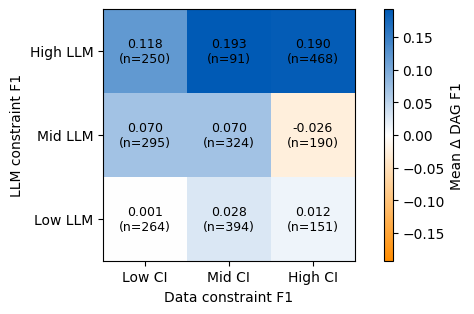

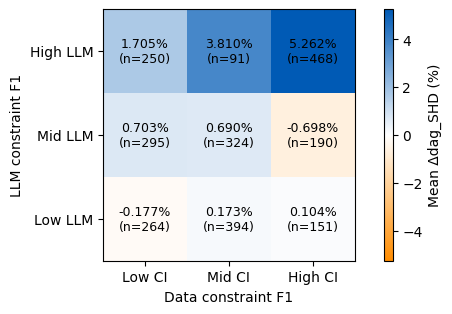

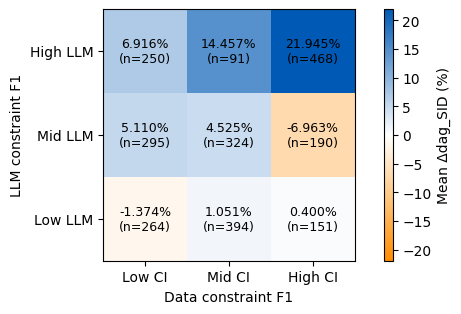

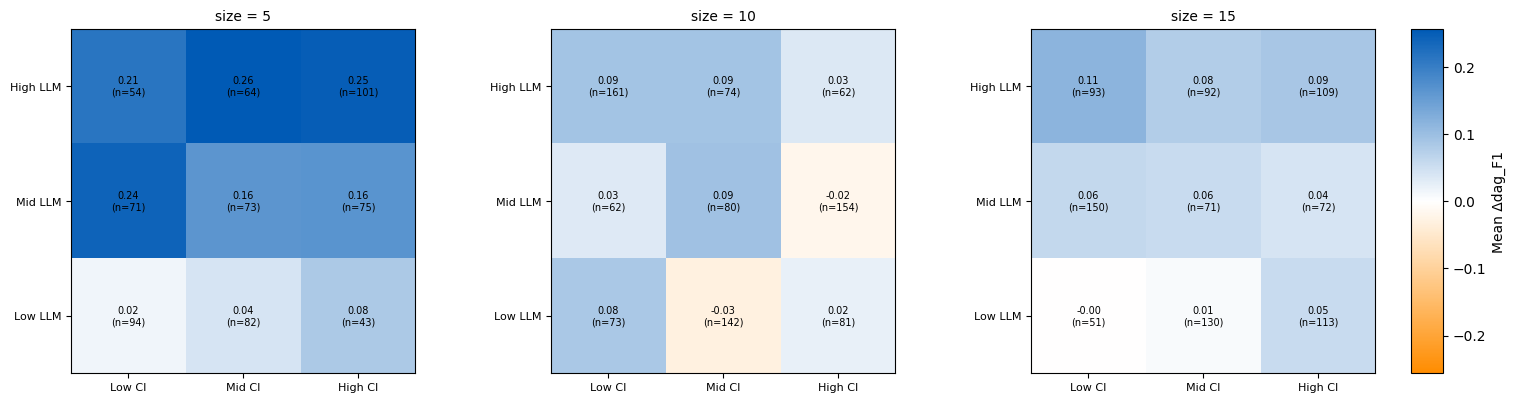

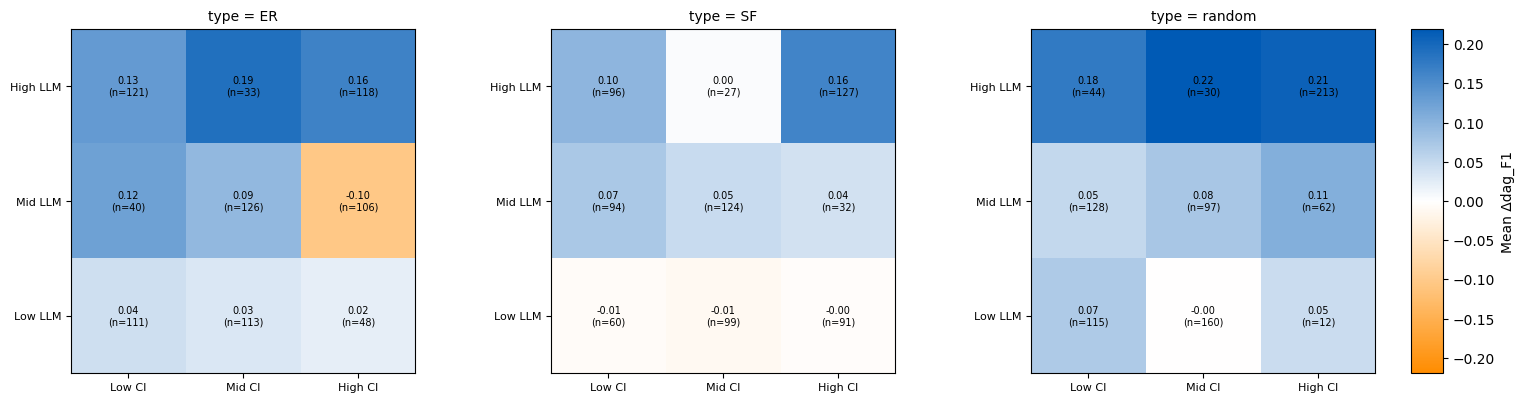

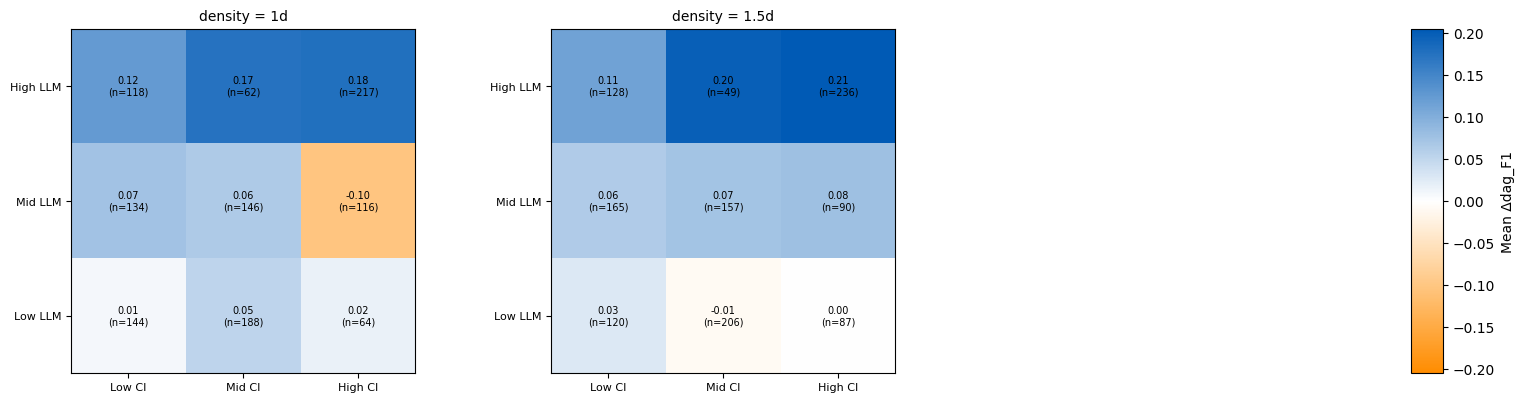

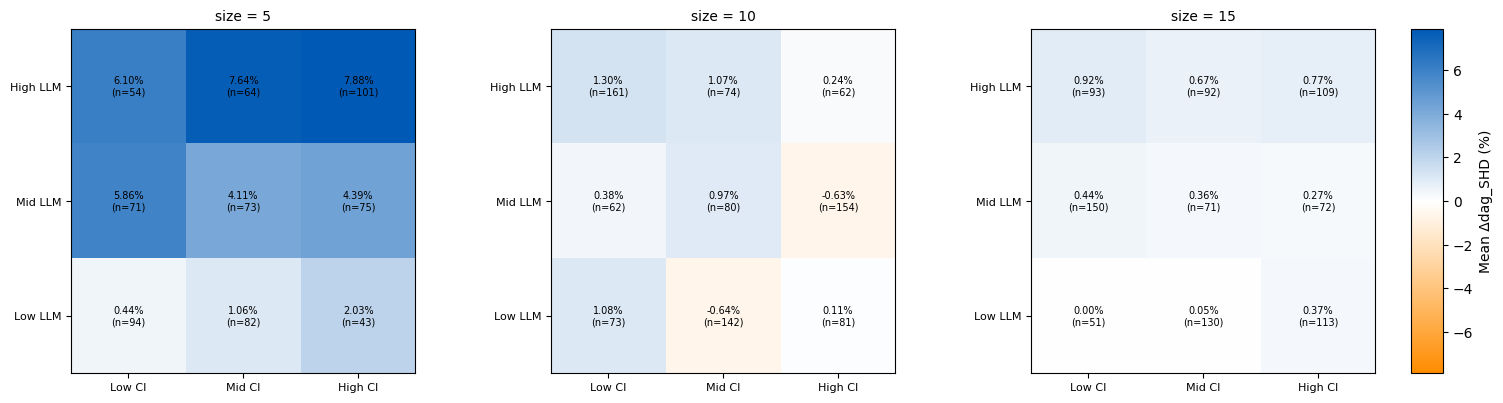

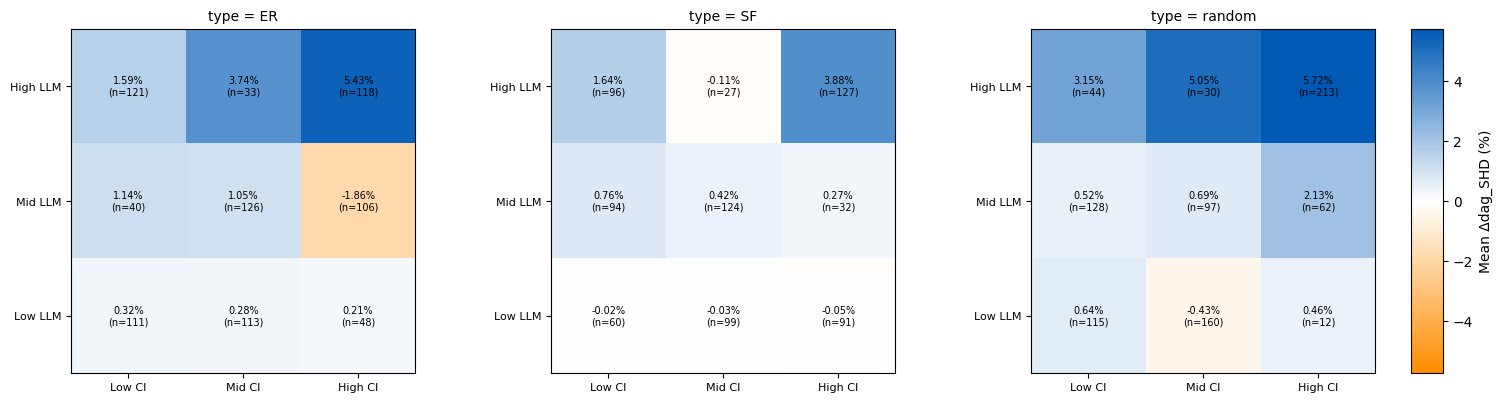

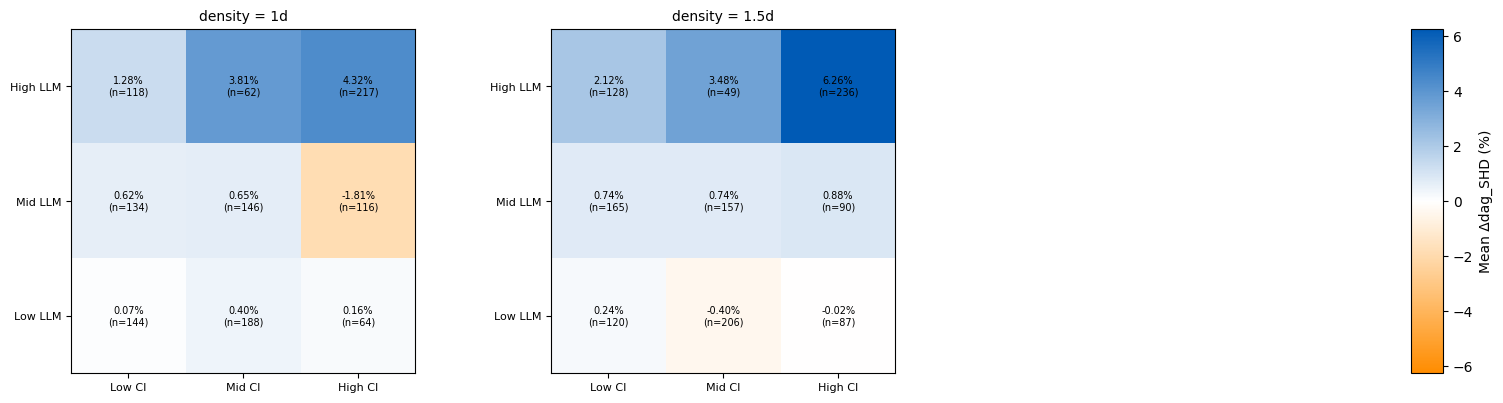

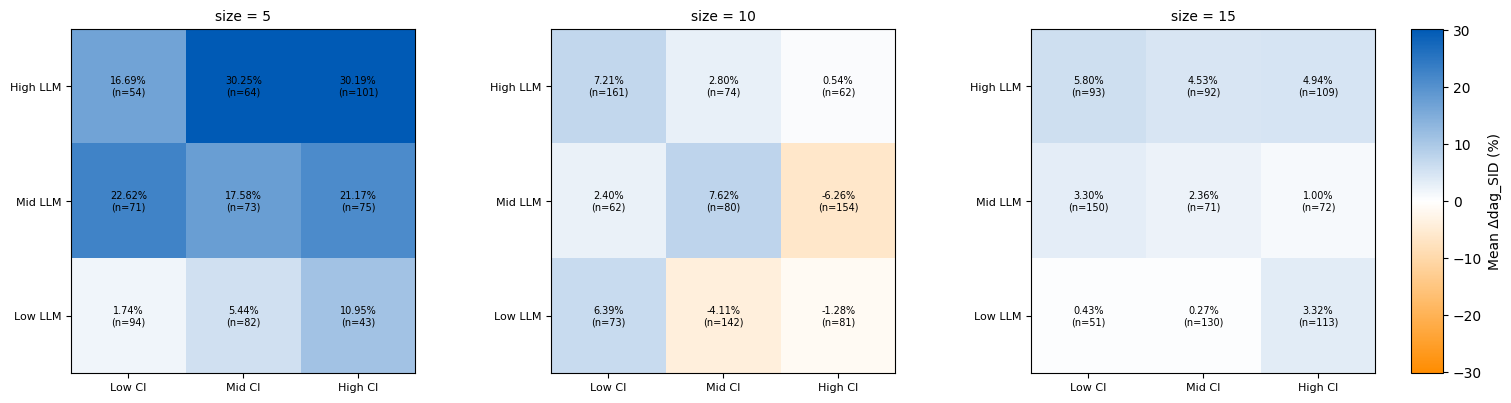

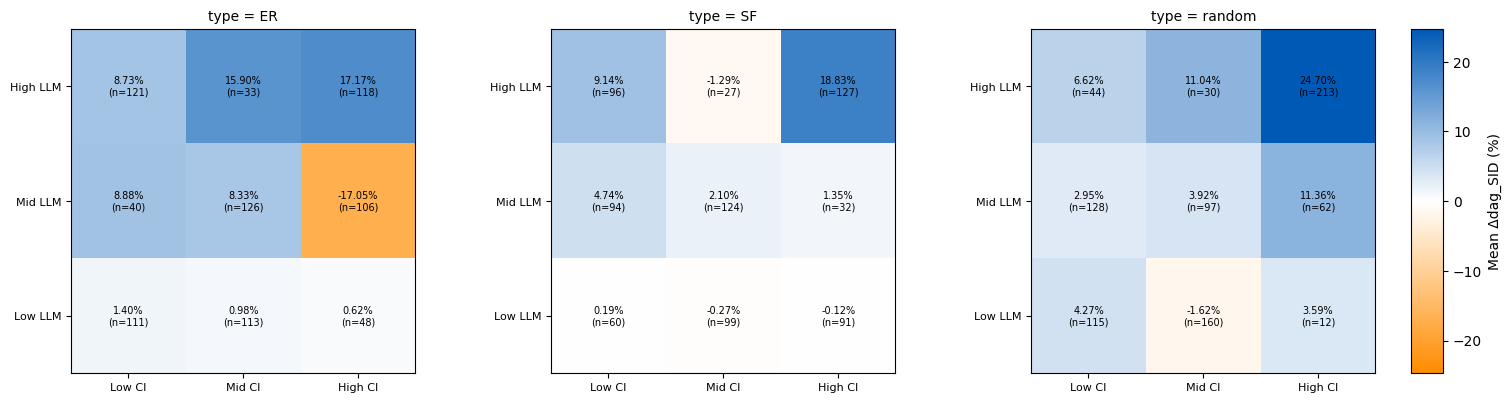

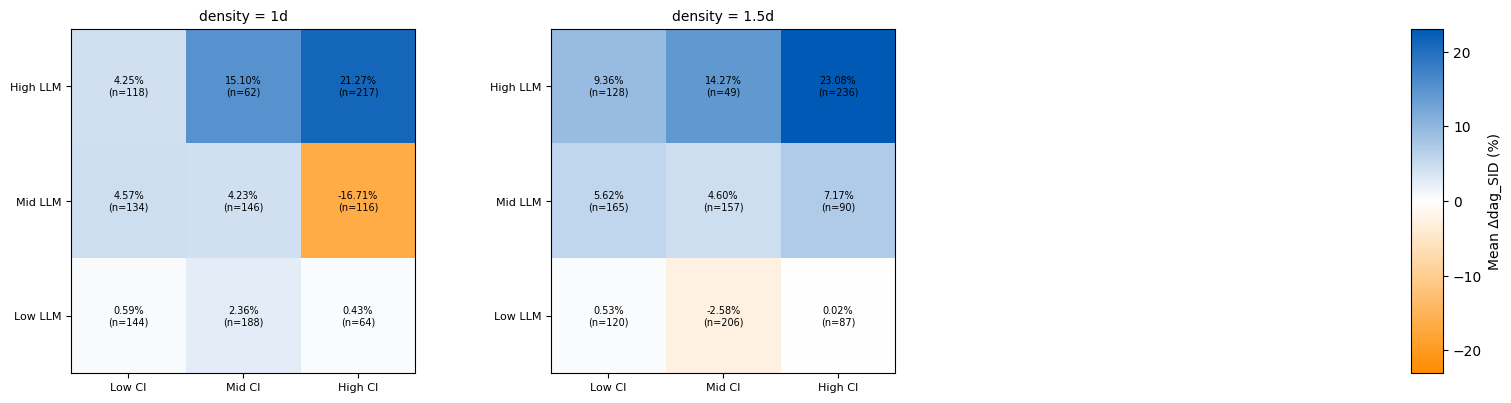

In [75]:
# Rebuild the heatmaps with robust 3-bin quantile binning (tie-safe) and include BOTH:
# 1) an aggregated 3×3 heatmap per metric, and
# 2) factor-split (size/type/density) 3×3 panels per metric.
#
# Tie-safe binning: use rank(method="first") to avoid qcut collapsing bins when there are many ties.
# Labels fixed to Low/Mid/High; bins are equal-count by construction.
#
# Outputs:
# - /mnt/data/strata_exports/newset_STRATA_q3_AGG.pdf
# - /mnt/data/strata_exports/newset_STRATA_q3_FACTORS.pdf

import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

INPATH = "../results/merged_synthetic 1.csv"  # input CSV from prior experiments
OUTDIR = "../results/strata_exports"  # output directory for PDF exports
os.makedirs(OUTDIR, exist_ok=True)

# ---------------- Load & aggregate ----------------
df_raw = pd.read_csv(INPATH)

## create a column that is the average of prior_forbidden_F1 and prior_required_F1
df_raw["prior_overall_F1"] = df_raw[["prior_forbidden_F1","prior_required_F1"]].mean(axis=1)

CI_COL = next((c for c in df_raw.columns if c.lower() in {"cit_f1","ci_f1","citf1"}), None)
# CI_COL = next((c for c in df_raw.columns if c.lower() in {"cit_precision","ci_precision","ciprecision"}), None)
# LLM_COL = "prior_forbidden_Precision" if "prior_forbidden_Precision" in df_raw.columns else ("AP" if "AP" in df_raw.columns else None)
LLM_COL = "prior_overall_F1" if "prior_overall_F1" in df_raw.columns else ("AP_F1" if "AP_F1" in df_raw.columns else None)
# LLM_COL = "prior_required_F1" if "prior_required_F1" in df_raw.columns else ("AP_F1" if "AP_F1" in df_raw.columns else None)
# LLM_COL = "prior_forbidden_F1" if "prior_forbidden_F1" in df_raw.columns else ("AP_F1" if "AP_F1" in df_raw.columns else None)
if CI_COL is None or LLM_COL is None:
    raise ValueError("Missing required columns (CIT_F1 and LLM quality).")

METRICS = ["dag_F1","dag_shd","dag_sid","cpdag_F1","cpdag_shd","cpdag_sid_low","cpdag_sid_high"]
keep_cols = ["dataset","seed","impl","num_nodes",CI_COL,LLM_COL] + [m for m in METRICS if m in df_raw.columns]
df_raw = df_raw[keep_cols].copy()

# Average over runs per (dataset, seed, impl)
agg = (df_raw
       .groupby(["dataset","seed","impl"], as_index=False)
       .mean(numeric_only=True))

# Average cpdag SID if present
if "cpdag_sid_low" in agg.columns and "cpdag_sid_high" in agg.columns:
    agg["cpdag_sid_avg"] = agg[["cpdag_sid_low","cpdag_sid_high"]].mean(axis=1)

# ---------------- Helpers ----------------
def parse_dataset_fields(name: str):
    size = None; gtype = "other"; density = None
    m = re.search(r"_(\d+)_nodes", name);  size = int(m.group(1)) if m else None
    if "ER" in name: gtype = "ER"
    elif "SF" in name: gtype = "SF"
    elif "random" in name.lower(): gtype = "random"
    m2 = re.search(r"_(\d+)_edges", name)
    if m2 and size:
        edges = int(m2.group(1)); ratio = edges/float(size)
        if abs(ratio-1.0) < 0.2: density = "1d"
        elif abs(ratio-1.5) < 0.3: density = "1.5d"
        else: density = f"{ratio:.1f}d"
    return size, gtype, density

def build_runlevel_avg(df_in: pd.DataFrame, metric_col: str, higher_is_better: bool, graph_kind: str):
    """Merge averaged org/new rows by (dataset,seed); use LLM quality from 'new' side."""
    ci = (df_in[df_in["impl"]=="org"]
          [["dataset","seed","num_nodes",CI_COL,metric_col]]
          .rename(columns={"num_nodes":"n_nodes_ci",CI_COL:"ci_quality",metric_col:"ci"}))
    cb = (df_in[df_in["impl"]=="new"]
          [["dataset","seed","num_nodes",CI_COL,LLM_COL,metric_col]]
          .rename(columns={"num_nodes":"n_nodes_new",CI_COL:"ci_quality_new",LLM_COL:"llm_quality",metric_col:"comb"}))
    m = pd.merge(cb, ci, on=["dataset","seed"], how="inner")
    m["n_nodes"] = m["n_nodes_new"].fillna(m["n_nodes_ci"])
    # parse factors
    parsed = m["dataset"].apply(parse_dataset_fields)
    m["size"] = [p[0] for p in parsed]
    m["type"] = [p[1] for p in parsed]
    m["density"] = [p[2] for p in parsed]
    # deltas
    if higher_is_better:
        m["delta"] = m["comb"] - m["ci"]; units=""
    else:
        n = m["n_nodes"].astype(float)
        capacity = n*(n-1) if graph_kind=="dag" else n*(n-1)/2.0
        capacity = capacity.replace(0, np.nan)
        m["delta"] = 100.0*(m["ci"] - m["comb"])/capacity; units="%"
    # qualities clipped
    m["ci_quality"] = pd.to_numeric(m["ci_quality"], errors="coerce").clip(0,1)
    m["llm_quality"] = pd.to_numeric(m["llm_quality"], errors="coerce").clip(0,1)
    return m, units

def make_cmap_blue_good_orange_bad():
    return LinearSegmentedColormap.from_list(
        "good_blue_bad_orange",
        [(255/255,140/255,0/255), (1,1,1), (0/255,90/255,181/255)],
        N=256
    )

def tie_safe_qcut_labels(series: pd.Series, labels):
    """Assign equal-count bins Low/Mid/High even with ties, using stable ranks."""
    s = pd.to_numeric(series, errors="coerce")
    ranks = s.rank(method="first")  # 1..n unique
    # normalise to (0,1]
    norm = ranks / (ranks.max() if ranks.max() else 1)
    cats = pd.qcut(norm, q=len(labels), labels=labels)
    return cats

def compute_grid_q3_equalcount(m: pd.DataFrame):
    ci_labels  = ["Low CI","Mid CI","High CI"]
    llm_labels = ["Low LLM","Mid LLM","High LLM"]
    m = m.dropna(subset=["ci_quality","llm_quality","delta"]).copy()
    m["ci_bin"]  = tie_safe_qcut_labels(m["ci_quality"],  ci_labels)
    m["llm_bin"] = tie_safe_qcut_labels(m["llm_quality"], llm_labels)
    row_order = list(m["llm_bin"].cat.categories)[::-1]  # better ↑
    col_order = list(m["ci_bin"].cat.categories)         # better →
    grid_mean = np.full((len(row_order), len(col_order)), np.nan)
    grid_count = np.zeros((len(row_order), len(col_order)), dtype=int)
    for i, rlab in enumerate(row_order):
        for j, clab in enumerate(col_order):
            vals = m.loc[(m["llm_bin"]==rlab) & (m["ci_bin"]==clab), "delta"].astype(float)
            if len(vals)>0:
                grid_mean[i,j] = float(vals.mean())
                grid_count[i,j] = int(len(vals))
    return grid_mean, grid_count, row_order, col_order

def plot_overall_q3_equalcount(m: pd.DataFrame, metric_label: str, units: str):
    grid_mean, grid_count, row_labels, col_labels = compute_grid_q3_equalcount(m)
    vmax = np.nanmax(np.abs(grid_mean)) if np.any(~np.isnan(grid_mean)) else 1.0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = make_cmap_blue_good_orange_bad()
    fig = plt.figure(figsize=(4.2,3.4))
    ax = fig.add_axes([0.12,0.16,0.66,0.74])
    im = ax.imshow(grid_mean, cmap=cmap, norm=norm, aspect="equal")
    ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels, fontsize=10)
    ax.set_yticks(range(len(row_labels))); ax.set_yticklabels(row_labels, fontsize=10)
    ax.set_xlabel("Data constraint F1")
    ax.set_ylabel("LLM constraint F1")
    for i in range(len(row_labels)):
        for j in range(len(col_labels)):
            if not np.isnan(grid_mean[i,j]):
                ax.text(j,i,f"{grid_mean[i,j]:.3f}{units}\n(n={grid_count[i,j]})",
                        ha="center", va="center", fontsize=9)
    cax = fig.add_axes([0.82,0.16,0.02,0.74]); cb = fig.colorbar(im, cax=cax)
    cb.set_label(f"Mean Δ{metric_label}{(' ('+units+')') if units else ''}")
    return fig

def section_page(title, subtitle=None):
    fig = plt.figure(figsize=(8.5, 11))
    ax = fig.add_axes([0.08, 0.10, 0.84, 0.80]); ax.axis("off")
    y = 0.75
    ax.text(0.5, y, title, ha="center", va="center", fontsize=22, fontweight="bold")
    if subtitle:
        ax.text(0.5, y-0.12, subtitle, ha="center", va="center", fontsize=11)
    ax.text(0.5, 0.12, datetime.now().strftime("%Y-%m-%d %H:%M"), ha="center", va="center", fontsize=8, color="gray")
    return fig

# ---------------- Build runlevels ----------------
run = {}; units = {}
def add(metric, hib, kind):
    if metric in agg.columns:
        r, u = build_runlevel_avg(agg, metric, hib, kind)
        run[metric] = r; units[metric] = u

add("dag_F1", True, "dag")
add("dag_shd", False, "dag")
add("dag_sid", False, "dag")
add("cpdag_F1", True, "cpdag")
add("cpdag_shd", False, "cpdag")
if "cpdag_sid_low" in agg.columns and "cpdag_sid_high" in agg.columns:
    agg["cpdag_sid_avg"] = agg[["cpdag_sid_low","cpdag_sid_high"]].mean(axis=1)
add("cpdag_sid_avg", False, "cpdag")

# ---------------- Factor Panels PDF ----------------
def levels_for_factor(m: pd.DataFrame, factor: str):
    s = m.dropna(subset=[factor])[factor]
    if factor == "size":
        return sorted(s.unique())
    if factor == "type":
        order = ["ER","SF","random","other"]
        return [x for x in order if x in s.unique()]
    if factor == "density":
        base = ["1d","1.5d"]
        extras = [d for d in s.unique() if d not in base]
        return [x for x in base if x in s.unique()] + sorted(extras)
    return sorted(s.unique())

def plot_factor_panels_q3(m: pd.DataFrame, metric_label: str, units: str, factor: str):
    lvls = levels_for_factor(m, factor)
    n = len(lvls); ncols = 3; nrows = int(np.ceil(n/ncols))
    fig = plt.figure(figsize=(4.6*ncols+2.2, 4.2*nrows))
    left, right, top, bottom = 0.06, 0.10, 0.08, 0.10
    wspace, hspace = 0.06, 0.08
    grid_w = 1 - left - right; grid_h = 1 - top - bottom
    cell_w = (grid_w - (ncols-1)*wspace)/ncols; cell_h = (grid_h - (nrows-1)*hspace)/nrows
    # shared scale
    vmax = 0.0; panels = []
    for lvl in lvls:
        sub = m[m[factor]==lvl]
        gm, gc, yl, xl = compute_grid_q3_equalcount(sub)
        vmax = max(vmax, np.nanmax(np.abs(gm)) if np.any(~np.isnan(gm)) else 0.0)
        panels.append((lvl, gm, gc, yl, xl))
    if vmax == 0: vmax = 1.0
    cmap = make_cmap_blue_good_orange_bad()
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    for idx, (lvl, gm, gc, yl, xl) in enumerate(panels):
        r = idx // ncols; c = idx % ncols
        ax = fig.add_axes([left + c*(cell_w+wspace), 1 - top - (r+1)*cell_h - r*hspace, cell_w, cell_h])
        im = ax.imshow(gm, cmap=cmap, norm=norm, aspect="equal")
        ax.set_xticks(range(len(xl))); ax.set_xticklabels(xl, fontsize=8)
        ax.set_yticks(range(len(yl))); ax.set_yticklabels(yl, fontsize=8)
        ax.set_title(f"{factor} = {lvl}", fontsize=10)
        for i in range(len(yl)):
            for j in range(len(xl)):
                if not np.isnan(gm[i,j]):
                    ax.text(j,i,f"{gm[i,j]:.2f}{units}\n(n={gc[i,j]})", ha="center", va="center", fontsize=7)
    cax = fig.add_axes([1 - right + 0.01, bottom, 0.02, grid_h])
    cb = fig.colorbar(im, cax=cax); cb.set_label(f"Mean Δ{metric_label}{(' ('+units+')') if units else ''}")
    # fig.suptitle(f"{metric_label} — 3×3 (Low/Mid/High) by {factor}", fontsize=14, y=0.995)
    return fig


# ---------------- Aggregated PDF ----------------
# PDF_AGG = os.path.join(OUTDIR, "newset_STRATA_q3_AGG.pdf")
# with PdfPages(PDF_AGG) as pdf:
#     pdf.savefig(section_page("New dataset — Aggregated 3×3 Heatmaps (q=3, tie-safe)",
#                              "Low / Mid / High bins via rank-based qcut to balance counts."))
#     # DAG
#     pdf.savefig(section_page("DAG Metrics"))
#     if "dag_F1" in run:   pdf.savefig(plot_overall_q3_equalcount(run["dag_F1"], "dag_F1", units["dag_F1"])); plt.close()
#     if "dag_shd" in run:  pdf.savefig(plot_overall_q3_equalcount(run["dag_shd"], "dag_SHD", units["dag_shd"])); plt.close()
#     if "dag_sid" in run:  pdf.savefig(plot_overall_q3_equalcount(run["dag_sid"], "dag_SID", units["dag_sid"])); plt.close()
#     # CPDAG
#     pdf.savefig(section_page("CPDAG Metrics"))
#     if "cpdag_F1" in run:     pdf.savefig(plot_overall_q3_equalcount(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"])); plt.close()
#     if "cpdag_shd" in run:    pdf.savefig(plot_overall_q3_equalcount(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"])); plt.close()
#     if "cpdag_sid_avg" in run: pdf.savefig(plot_overall_q3_equalcount(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"])); plt.close()

### ---------------- Factor Panels PDF ----------------
# PDF_FACTORS = os.path.join(OUTDIR, "newset_STRATA_q3_FACTORS.pdf")
# with PdfPages(PDF_FACTORS) as pdf:
#     pdf.savefig(section_page("New dataset — Factor Panels (q=3, tie-safe)",
#                              "Panels by size, type, density. Blue=improve, Orange=worse."))
#     # DAG
#     pdf.savefig(section_page("DAG Metrics"))
#     if "dag_F1" in run:
#         pdf.savefig(plot_factor_panels_q3(run["dag_F1"], "dag_F1", units["dag_F1"], "size")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["dag_F1"], "dag_F1", units["dag_F1"], "type")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["dag_F1"], "dag_F1", units["dag_F1"], "density")); plt.close()
#     if "dag_shd" in run:
#         pdf.savefig(plot_factor_panels_q3(run["dag_shd"], "dag_SHD", units["dag_shd"], "size")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["dag_shd"], "dag_SHD", units["dag_shd"], "type")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["dag_shd"], "dag_SHD", units["dag_shd"], "density")); plt.close()
#     if "dag_sid" in run:
#         pdf.savefig(plot_factor_panels_q3(run["dag_sid"], "dag_SID", units["dag_sid"], "size")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["dag_sid"], "dag_SID", units["dag_sid"], "type")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["dag_sid"], "dag_SID", units["dag_sid"], "density")); plt.close()
#     # CPDAG
#     pdf.savefig(section_page("CPDAG Metrics"))
#     if "cpdag_F1" in run:
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"], "size")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"], "type")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"], "density")); plt.close()
#     if "cpdag_shd" in run:
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"], "size")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"], "type")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"], "density")); plt.close()
#     if "cpdag_sid_avg" in run:
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"], "size")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"], "type")); plt.close()
#         pdf.savefig(plot_factor_panels_q3(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"], "density")); plt.close()

# PDF_AGG, PDF_FACTORS

### ------------------ Print Plots to Copy and Paste ----------------

# DAG
### Overall plot
plot_overall_q3_equalcount(run["dag_F1"], " DAG F1", units["dag_F1"])
plot_overall_q3_equalcount(run["dag_shd"], "dag_SHD", units["dag_shd"])
plot_overall_q3_equalcount(run["dag_sid"], "dag_SID", units["dag_sid"])

if "dag_F1" in run:
    plot_factor_panels_q3(run["dag_F1"], "dag_F1", units["dag_F1"], "size")
    plot_factor_panels_q3(run["dag_F1"], "dag_F1", units["dag_F1"], "type")
    plot_factor_panels_q3(run["dag_F1"], "dag_F1", units["dag_F1"], "density")
if "dag_shd" in run:
    plot_factor_panels_q3(run["dag_shd"], "dag_SHD", units["dag_shd"], "size")
    plot_factor_panels_q3(run["dag_shd"], "dag_SHD", units["dag_shd"], "type")
    plot_factor_panels_q3(run["dag_shd"], "dag_SHD", units["dag_shd"], "density")
if "dag_sid" in run:
    plot_factor_panels_q3(run["dag_sid"], "dag_SID", units["dag_sid"], "size")
    plot_factor_panels_q3(run["dag_sid"], "dag_SID", units["dag_sid"], "type")
    plot_factor_panels_q3(run["dag_sid"], "dag_SID", units["dag_sid"], "density")

# # CPDAG
# if "cpdag_F1" in run:
#     plot_factor_panels_q3(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"], "size")
#     plot_factor_panels_q3(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"], "type")
#     plot_factor_panels_q3(run["cpdag_F1"], "cpdag_F1", units["cpdag_F1"], "density")
# if "cpdag_shd" in run:
#     plot_factor_panels_q3(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"], "size")
#     plot_factor_panels_q3(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"], "type")
#     plot_factor_panels_q3(run["cpdag_shd"], "cpdag_SHD", units["cpdag_shd"], "density")
# if "cpdag_sid_avg" in run:
#     plot_factor_panels_q3(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"], "size")
#     plot_factor_panels_q3(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"], "type")
#     plot_factor_panels_q3(run["cpdag_sid_avg"], "cpdag_SID avg", units["cpdag_sid_avg"], "density")
